In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from scipy import stats, spatial
import pickle
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [2]:
tfidf_path = '../../data/tfidf_merged_chs_202001_full/'

In [44]:
lda_path = '../../data/lda_merged_chs_202001_full/'

In [45]:
fandom_list = [i for i in os.listdir(lda_path) if 'tsv' in i]

In [46]:
fandom_list

['hetalia_axis_powers_temporal_lda_jsd_toprev_with_dist_merged_chs_no_text.tsv',
 'doctor_who_&_related_fandoms_temporal_lda_jsd_toprev_with_dist_merged_chs_no_text.tsv',
 'attack_on_titan_temporal_lda_jsd_toprev_with_dist_merged_chs_no_text.tsv',
 'buffy_the_vampire_slayer_temporal_lda_jsd_toprev_with_dist_merged_chs_no_text.tsv',
 'the_walking_dead_&_related_fandoms_temporal_lda_jsd_toprev_with_dist_merged_chs_no_text.tsv',
 'shakespare_william_works_temporal_lda_jsd_toprev_with_dist_merged_chs_no_text.tsv',
 'dragon_age_all_media_types_temporal_lda_jsd_toprev_with_dist_merged_chs_no_text.tsv',
 'sherlock_holmes_&_related_fandoms_temporal_lda_jsd_toprev_with_dist_merged_chs_no_text.tsv',
 'harry_potter_temporal_lda_jsd_toprev_with_dist_merged_chs_no_text.tsv',
 'arthurian_mythology_&_related_fandoms_temporal_lda_jsd_toprev_with_dist_merged_chs_no_text.tsv',
 'one_direction_temporal_lda_jsd_toprev_with_dist_merged_chs_no_text.tsv',
 'tolkien_j_r_r_works_&_related_fandoms_temporal_lda_

In [47]:
df = pd.read_csv(os.path.join(lda_path,'sherlock_holmes_&_related_fandoms_temporal_lda_jsd_toprev_with_dist_merged_chs_no_text.tsv'), sep = '\t')

In [48]:
len(df)

43200

In [49]:
def var_bootstrap_resample(li):
    if len(li) > 0:
        var_original = np.var(li)
        var_s = []
        for i in range(100):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            var_s.append(np.var(sample))
        tail = sorted(var_s)[5]
        head = sorted(var_s)[95]
        return (var_original, tail, head)

In [50]:
def ave_bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        ave_s = []
        for i in range(100):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            ave_s.append(np.average(sample))
        tail = sorted(ave_s)[5]
        head = sorted(ave_s)[95]
        return (ave_original, tail, head)

In [51]:
def create_normed_dfs(df, field):

#     turn into z scores
    df[field] = np.log(df[field]+1)
    df = df.replace([np.inf, -np.inf], np.nan)
    df[field].dropna()
    df[field] = (df[field] - df[field].mean())/df[field].std(ddof=0)

    return df

In [52]:
def create_dict(df, nov_field, suc_field, metric):
    
    # Make bins
    df[nov_field] = df[nov_field].astype(float)
    term_n = sorted(df[nov_field].tolist())
    term_n = np.quantile(term_n, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    term_n = np.insert(term_n, 0, 0)
    term_n = np.concatenate([term_n, [1]])
    dic = {}
    for i in range(len(term_n)-1):
        df_s = df[(df[nov_field] >= term_n[i]) & (df[nov_field] < term_n[i+1])]
        li = df_s[suc_field].tolist()
        if len(li) > 0:
            if metric == 'ave':
                dic[term_n[i]] = ave_bootstrap_resample(li)
            elif metric == 'var':
                dic[term_n[i]] = var_bootstrap_resample(li)
    return dic

In [53]:
def generate_res(path, nov_field, suc_field, metric):
    df_all = []
    fandom_list = [i for i in os.listdir(path) if 'tsv' in i]
    for i,fandom in enumerate(fandom_list):
        df = pd.read_csv(os.path.join(path,fandom), sep = '\t')
        df = create_normed_dfs(df, suc_field)
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df[[nov_field, suc_field]].dropna()
        df_all.append(df)

    df = pd.concat(df_all)
    df = df.sort_values(by = nov_field)
    df = df.sort_values(by = suc_field)
    dic = create_dict(df, nov_field, suc_field, metric)

    return dic
    

In [54]:
def generate_save_dics(suffix='None'):
    lda_kudos_dict_var = generate_res(lda_path, 'JSD','Kudos', 'var')
    lda_hits_dict_var = generate_res(lda_path, 'JSD','Hits', 'var')
    lda_comments_dict_var = generate_res(lda_path, 'JSD','Comments', 'var')
    lda_bookmarks_dict_var = generate_res(lda_path, 'JSD','Bookmarks', 'var')
    pickle.dump(lda_kudos_dict_var, open('lda_kudos_dict_var_{}.p'.format(suffix), 'wb'))
    pickle.dump(lda_hits_dict_var, open('lda_hits_dict_var_{}.p'.format(suffix), 'wb'))
    pickle.dump(lda_comments_dict_var, open('lda_comments_dict_var_{}.p'.format(suffix), 'wb'))
    pickle.dump(lda_bookmarks_dict_var, open('lda_bookmarks_dict_var_{}.p'.format(suffix), 'wb'))
    
    tfidf_kudos_dict_var = generate_res(tfidf_path, 'Cos', 'Kudos', 'var')
    tfidf_hits_dict_var = generate_res(tfidf_path, 'Cos', 'Hits', 'var')
    tfidf_comments_dict_var = generate_res(tfidf_path, 'Cos', 'Comments', 'var')
    tfidf_bookmarks_dict_var = generate_res(tfidf_path, 'Cos', 'Bookmarks', 'var')
    pickle.dump(tfidf_kudos_dict_var, open('tfidf_kudos_dict_var_{}.p'.format(suffix), 'wb'))
    pickle.dump(tfidf_hits_dict_var, open('tfidf_hits_dict_var_{}.p'.format(suffix), 'wb'))
    pickle.dump(tfidf_comments_dict_var, open('tfidf_comments_dict_var_{}.p'.format(suffix), 'wb'))
    pickle.dump(tfidf_bookmarks_dict_var, open('tfidf_bookmarks_dict_var_{}.p'.format(suffix), 'wb'))
    
    lda_kudos_dict_ave = generate_res(lda_path, 'JSD','Kudos', 'ave')
    lda_hits_dict_ave = generate_res(lda_path, 'JSD','Hits', 'ave')
    lda_comments_dict_ave = generate_res(lda_path, 'JSD','Comments', 'ave')
    lda_bookmarks_dict_ave = generate_res(lda_path, 'JSD','Bookmarks', 'ave')
    pickle.dump(lda_kudos_dict_ave, open('lda_kudos_dict_ave_{}.p'.format(suffix), 'wb'))
    pickle.dump(lda_hits_dict_ave, open('lda_hits_dict_ave_{}.p'.format(suffix), 'wb'))
    pickle.dump(lda_comments_dict_ave, open('lda_comments_dict_ave_{}.p'.format(suffix), 'wb'))
    pickle.dump(lda_bookmarks_dict_ave, open('lda_bookmarks_dict_ave_{}.p'.format(suffix), 'wb'))
    
    tfidf_kudos_dict_ave = generate_res(tfidf_path, 'Cos', 'Kudos', 'ave')
    tfidf_hits_dict_ave = generate_res(tfidf_path, 'Cos', 'Hits', 'ave')
    tfidf_comments_dict_ave = generate_res(tfidf_path, 'Cos', 'Comments', 'ave')
    tfidf_bookmarks_dict_ave = generate_res(tfidf_path, 'Cos', 'Bookmarks', 'ave')
    pickle.dump(tfidf_kudos_dict_ave, open('tfidf_kudos_dict_ave_{}.p'.format(suffix), 'wb'))
    pickle.dump(tfidf_hits_dict_ave, open('tfidf_hits_dict_ave_{}.p'.format(suffix), 'wb'))
    pickle.dump(tfidf_comments_dict_ave, open('tfidf_comments_dict_ave_{}.p'.format(suffix), 'wb'))
    pickle.dump(tfidf_bookmarks_dict_ave, open('tfidf_bookmarks_dict_ave_{}.p'.format(suffix), 'wb'))

In [56]:
generate_save_dics(suffix='full_merged_chs')

In [3]:
def load_dics(suffix='None'):
    global lda_kudos_dict_var, lda_hits_dict_var, lda_comments_dict_var, lda_bookmarks_dict_var
    global tfidf_kudos_dict_ave, tfidf_hits_dict_ave, tfidf_comments_dict_ave, tfidf_bookmarks_dict_ave
    global lda_kudos_dict_ave, lda_hits_dict_ave, lda_comments_dict_ave, lda_bookmarks_dict_ave
    global tfidf_kudos_dict_var, tfidf_hits_dict_var, tfidf_comments_dict_var, tfidf_bookmarks_dict_var
    lda_kudos_dict_var = pickle.load(open('lda_kudos_dict_var_{}.p'.format(suffix), 'rb'))
    lda_hits_dict_var = pickle.load(open('lda_hits_dict_var_{}.p'.format(suffix), 'rb'))
    lda_comments_dict_var = pickle.load(open('lda_comments_dict_var_{}.p'.format(suffix), 'rb'))
    lda_bookmarks_dict_var = pickle.load(open('lda_bookmarks_dict_var_{}.p'.format(suffix), 'rb'))
    
    tfidf_kudos_dict_ave = pickle.load(open('tfidf_kudos_dict_ave_{}.p'.format(suffix), 'rb'))
    tfidf_hits_dict_ave = pickle.load(open('tfidf_hits_dict_ave_{}.p'.format(suffix), 'rb'))
    tfidf_comments_dict_ave = pickle.load(open('tfidf_comments_dict_ave_{}.p'.format(suffix), 'rb'))
    tfidf_bookmarks_dict_ave = pickle.load(open('tfidf_bookmarks_dict_ave_{}.p'.format(suffix), 'rb'))
    
    lda_kudos_dict_ave = pickle.load(open('lda_kudos_dict_ave_{}.p'.format(suffix), 'rb'))
    lda_hits_dict_ave = pickle.load(open('lda_hits_dict_ave_{}.p'.format(suffix), 'rb'))
    lda_comments_dict_ave = pickle.load(open('lda_comments_dict_ave_{}.p'.format(suffix), 'rb'))
    lda_bookmarks_dict_ave = pickle.load(open('lda_bookmarks_dict_ave_{}.p'.format(suffix), 'rb'))
    
    tfidf_kudos_dict_var = pickle.load(open('tfidf_kudos_dict_var_{}.p'.format(suffix), 'rb'))
    tfidf_hits_dict_var = pickle.load(open('tfidf_hits_dict_var_{}.p'.format(suffix), 'rb'))
    tfidf_comments_dict_var = pickle.load(open('tfidf_comments_dict_var_{}.p'.format(suffix), 'rb'))
    tfidf_bookmarks_dict_var = pickle.load(open('tfidf_bookmarks_dict_var_{}.p'.format(suffix), 'rb'))
    
    

In [4]:
load_dics(suffix='full_merged_chs')

In [5]:
def create_xs(keys):
    xs = []
    for i in range(len(keys)-1):
        xs.append(keys[i] + (keys[i+1] - keys[i])/2)
    return xs

In [6]:
def extract_plot_vals(dic):
    keys = sorted(dic.keys())
    keys.append(1)
    x = create_xs(keys)
    y = [dic[j][0] for j in keys[:-1]]
    lower_error = [dic[j][0] - dic[j][1] for j in keys[:-1]]
    upper_error = [dic[j][2] - dic[j][0] for j in keys[:-1]]
    asymmetric_error = [lower_error, upper_error]
    return x,y,asymmetric_error

In [7]:
lda_kudos_dict_ave.keys()

dict_keys([0.0, 0.11372755032061832, 0.15728255944304692, 0.1962929380563309, 0.2338936429887326, 0.27100075879934593, 0.3079763471650949, 0.34696120511216577, 0.3911094319046242, 0.4489989240839805])

In [8]:
x,y,e = extract_plot_vals(lda_kudos_dict_ave)
print(x)

[0.05686377516030916, 0.13550505488183262, 0.17678774874968892, 0.21509329052253176, 0.25244720089403927, 0.2894885529822204, 0.32746877613863035, 0.369035318508395, 0.42005417799430234, 0.7244994620419902]


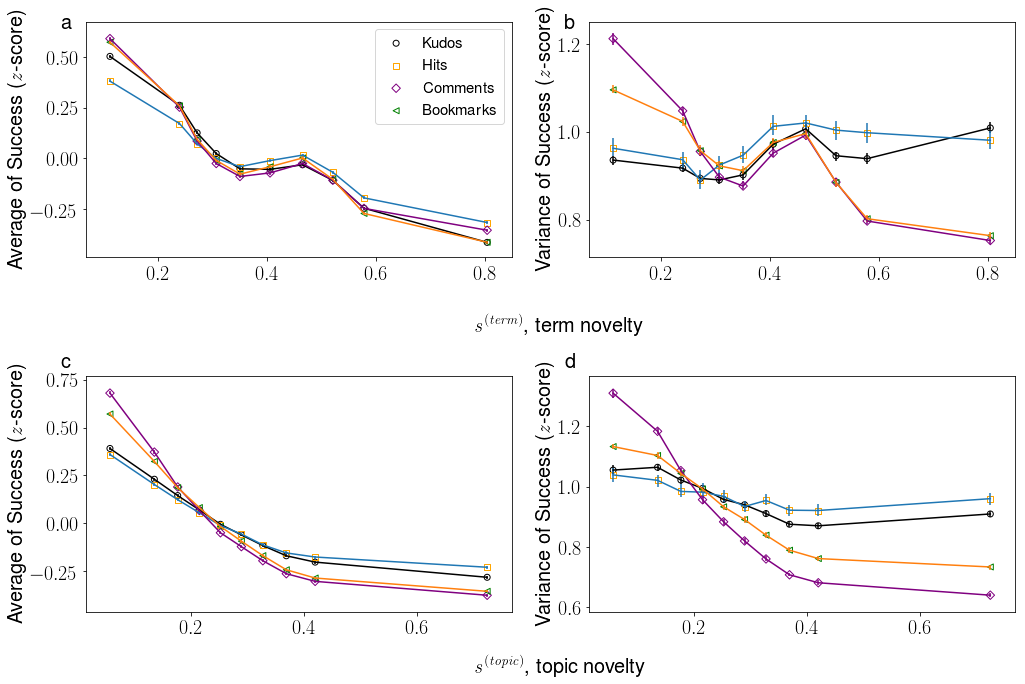

In [48]:
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(bottom = 0.4)


plt.subplot(2, 2, 1)

x, y, err = extract_plot_vals(tfidf_kudos_dict_ave)
plt.errorbar(x, y, yerr=err, color='black')
plt.scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

x, y, err = extract_plot_vals(tfidf_hits_dict_ave)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

x, y, err = extract_plot_vals(tfidf_comments_dict_ave)
plt.errorbar(x, y, yerr=err, c='purple')
plt.scatter(x, y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

x, y, err = extract_plot_vals(tfidf_bookmarks_dict_ave)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')

plt.legend(prop={'size': 15})
plt.ylabel('Average of Success ($\it{z}$-score)',fontsize=20)
plt.tick_params(labelsize=20)

# fig.text(0.03, 0.45, 'Variance in Success ($\it{z}$-score)', ha='center', va='center', rotation='vertical', fontsize=15)

plt.subplot(2, 2, 2)

x, y, err = extract_plot_vals(tfidf_kudos_dict_var)
plt.errorbar(x, y, yerr=err, color='black')
plt.scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

x, y, err = extract_plot_vals(tfidf_hits_dict_var)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

x, y, err = extract_plot_vals(tfidf_comments_dict_var)
plt.errorbar(x, y, yerr=err, c='purple')
plt.scatter(x, y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

x, y, err = extract_plot_vals(tfidf_bookmarks_dict_var)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')
plt.ylabel('Variance of Success ($\it{z}$-score)',fontsize=20)
# plt.legend()
plt.tick_params(labelsize=20)


plt.subplot(2, 2, 3)

x, y, err = extract_plot_vals(lda_kudos_dict_ave)
plt.errorbar(x, y, yerr=err, color='black')
plt.scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

x, y, err = extract_plot_vals(lda_hits_dict_ave)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

x, y, err = extract_plot_vals(lda_comments_dict_ave)
plt.errorbar(x, y, yerr=err, c='purple')
plt.scatter(x, y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

x, y, err = extract_plot_vals(lda_bookmarks_dict_ave)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')

# plt.legend(prop={'size': 15})
plt.ylabel('Average of Success ($\it{z}$-score)',fontsize=20)
plt.tick_params(labelsize=20)

# fig.text(0.03, 0.45, 'Variance in Success ($\it{z}$-score)', ha='center', va='center', rotation='vertical', fontsize=15)

plt.subplot(2, 2, 4)

x, y, err = extract_plot_vals(lda_kudos_dict_var)
plt.errorbar(x, y, yerr=err, color='black')
plt.scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

x, y, err = extract_plot_vals(lda_hits_dict_var)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

x, y, err = extract_plot_vals(lda_comments_dict_var)
plt.errorbar(x, y, yerr=err, c='purple')
plt.scatter(x, y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

x, y, err = extract_plot_vals(lda_bookmarks_dict_var)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')
plt.tick_params(labelsize=20)


# plt.legend(prop={'size': 15})
# plt.xlabel('$\it{s}^{(topic)}$, topic novelty', fontsize = 15)
plt.ylabel('Variance of Success ($\it{z}$-score)',fontsize=20)

fig.text(0.45, 0.48, '$\it{s}^{(term)}$, term novelty',fontsize=20)
fig.text(0.45, 0.006, '$\it{s}^{(topic)}$, topic novelty',fontsize=20)
fig.text(0.04, 0.9, 'a',fontsize=20)
fig.text(0.54, 0.9, 'b',fontsize=20)
fig.text(0.04, 0.43, 'c',fontsize=20)
fig.text(0.54, 0.43, 'd',fontsize=20)


plt.tight_layout()
plt.savefig('scatter_var_ave_merged.pdf', type='pdf')


/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


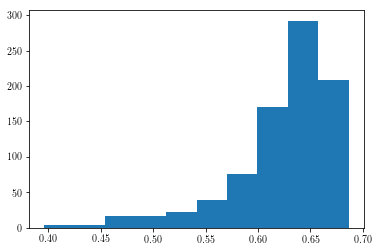

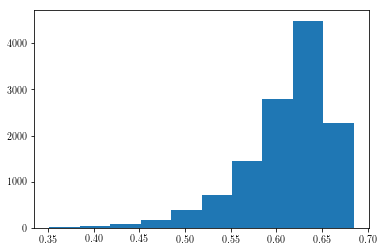

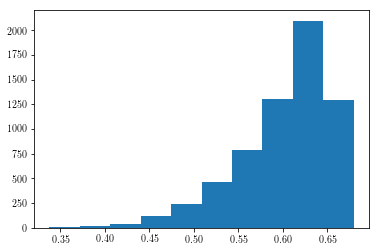

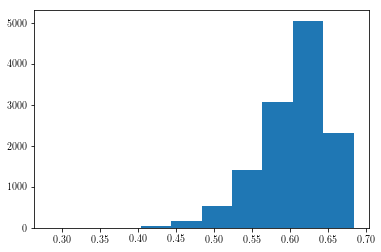

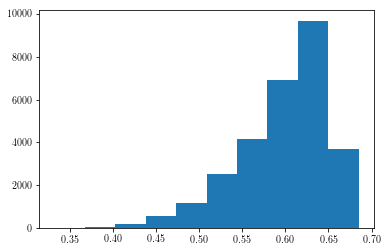

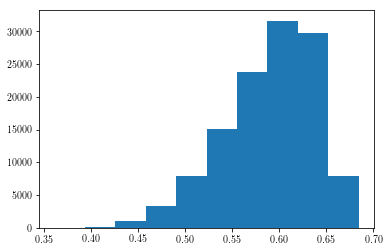

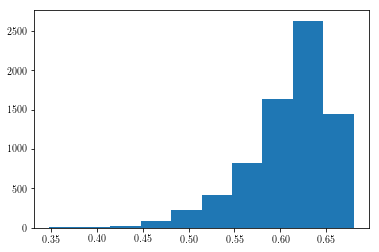

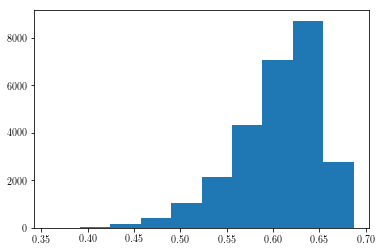

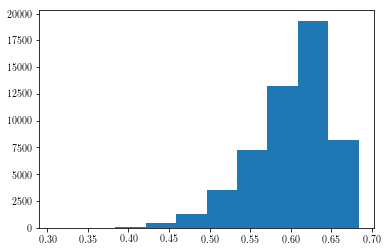

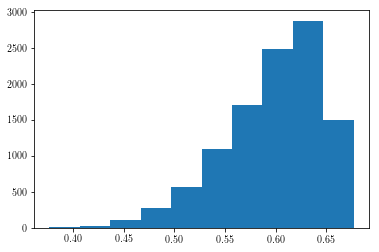

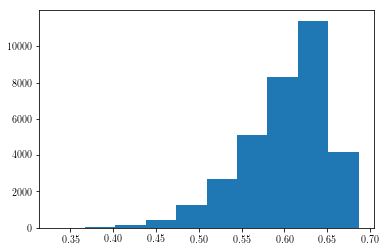

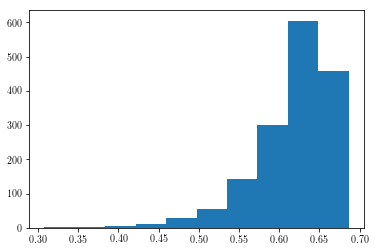

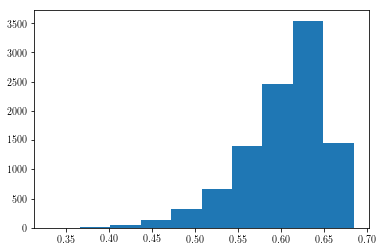

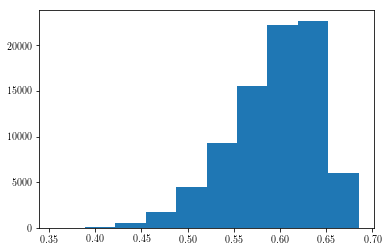

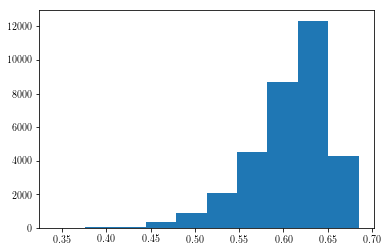

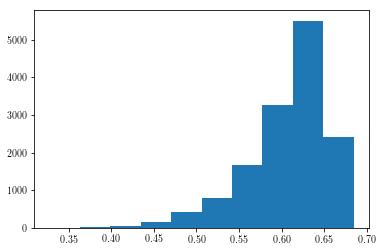

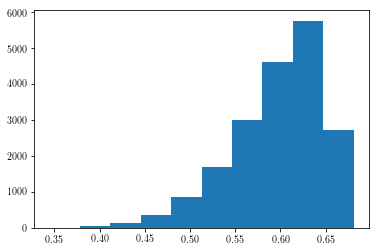

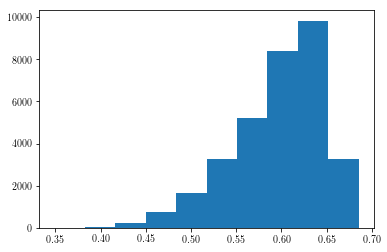

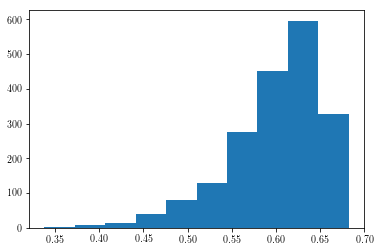

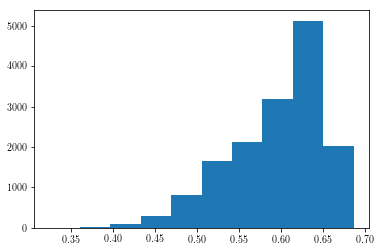

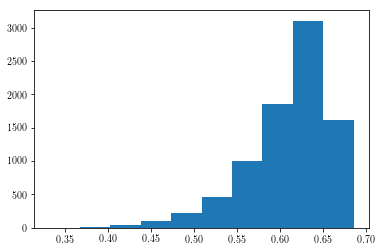

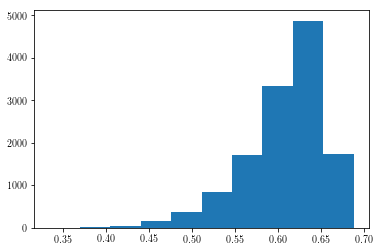

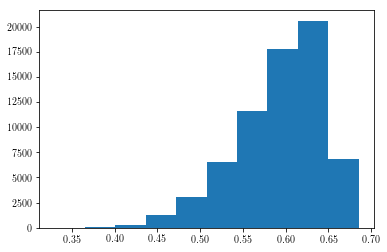

In [39]:
fandom_list = [i for i in os.listdir(lda_path) if 'tsv' in i]
for i,fandom in enumerate(fandom_list):
    df = pd.read_csv(os.path.join(lda_path,fandom), sep = '\t')
    plt.figure()
    plt.hist(df.JSD.tolist())
#     plt.title(str(fandom))

/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


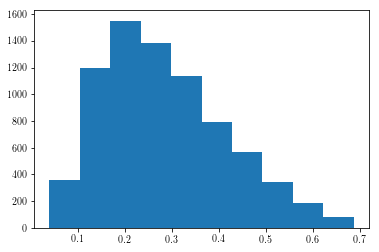

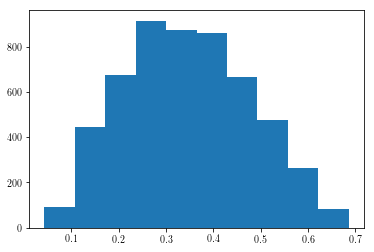

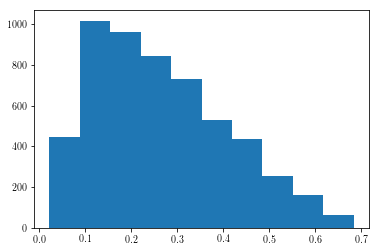

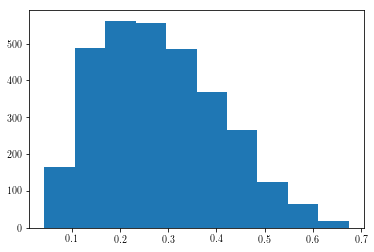

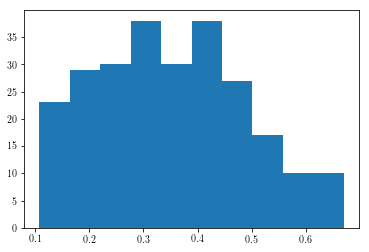

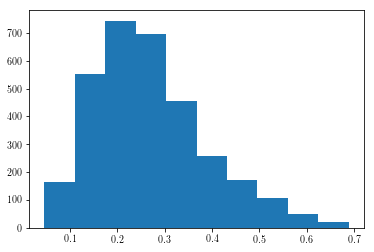

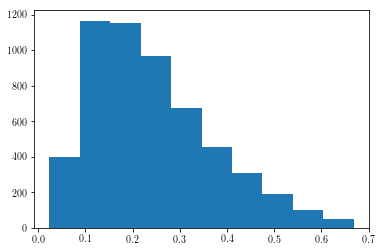

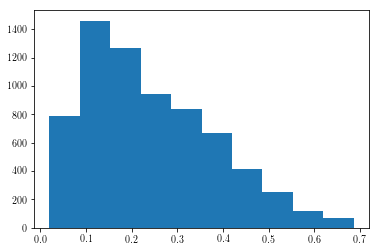

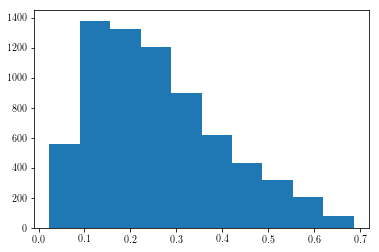

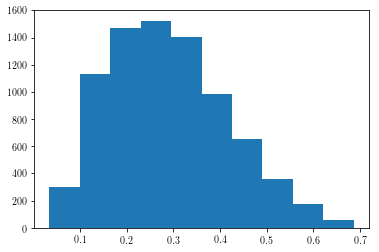

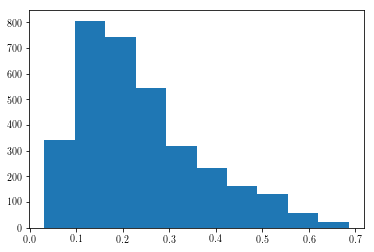

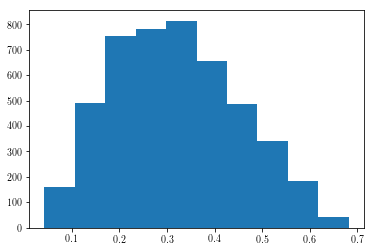

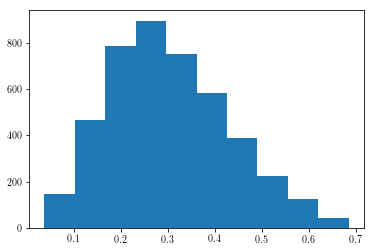

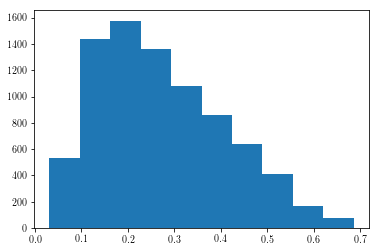

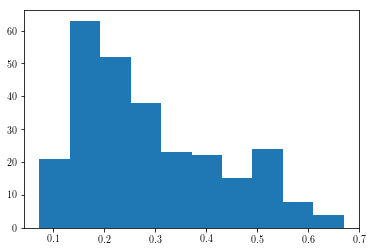

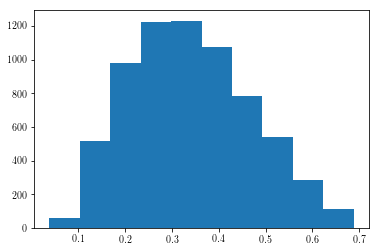

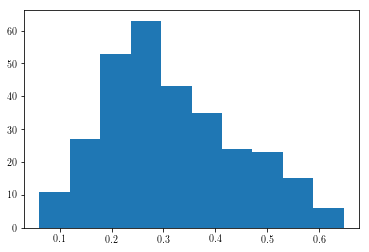

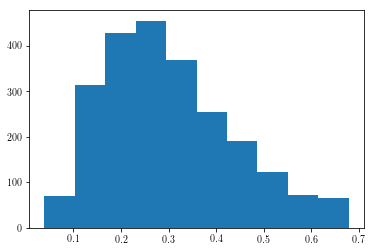

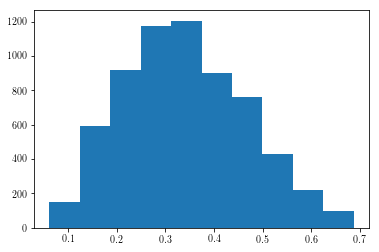

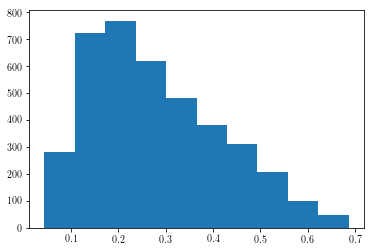

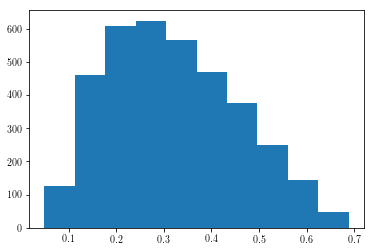

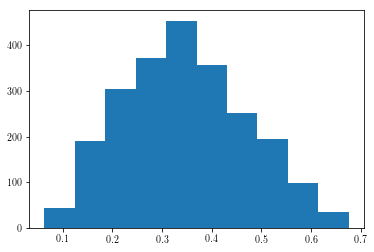

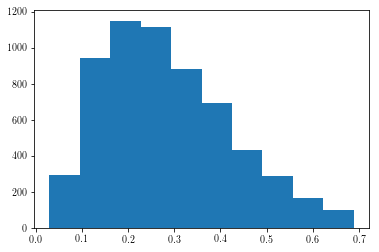

In [41]:
lda_path_2 = '../../data/lda_merged_chs_202001/'
fandom_list = [i for i in os.listdir(lda_path_2) if 'tsv' in i]
for i,fandom in enumerate(fandom_list):
    df = pd.read_csv(os.path.join(lda_path_2,fandom), sep = '\t')
    plt.figure()
    plt.hist(df.JSD.tolist())
#     plt.title(str(fandom))